581
['6723', '9675', '9671', '6528', '9777', '8095', '5989', '3553', '4148', '4144', '3253', '1947', '341', '817', '5460', '3336', '6844', '7121', '4732', '6797', '4731', '9230', '2314', '199', '596', '196', '1126', '3148', '4659', '2821', '3675', '8734', '2267', '8041', '3583', '4211', '8045', '1233', '444', '5670', '6933', '2286', '8127', '6938', '5775', '6508', '1842', '4819', '2048', '9559', '3096', '6370', '2616', '331', '4907', '4107', '9630', '8190', '8196', '5701', '5703', '6203', '3890', '6208', '3894', '3895', '4777', '5186', '8839', '9948', '8938', '8833', '2869', '7170', '7676', '7674', '2224', '1758', '8166', '9111', '9446', '617', '5536', '1885', '3704', '2123', '942', '7180', '6031', '1479', '8642', '875', '5175', '9367', '9360', '3412', '8548', '494', '9162', '5075', '9838', '6575', '7592', '5589', '6248', '7695', '939', '935', '6796', '1068', '9068', '1956', '7314', '3245', '7522', '3842', '3847', '373', '1488', '5252', '1712', '6787', '6786', '5316', '4723', '6665', '

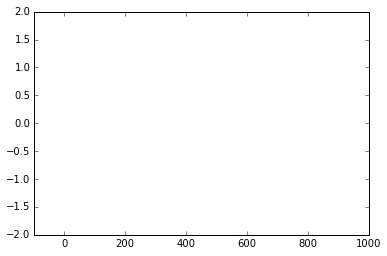

In [26]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
varlist = varlist = ['MJD','FLT','FIELD','FLUXCAL','FLUXCALERR','PHOTFLAG','TEMPLERR','ZPT','SNR','MAG','MAGERR','SIM_MAGOBS']
cutwin_ZP = [30.5,34.0]
cutwin_SNR = 5
nitesep = [3,8]

# read in all the necessary data and make a list with each element a list of the values in each row of the data table
def parsefiles(files):
    # read in all the necessary data and make a list with each element a list of the values in each row of the data table
    # -------------------------------
    import re # import needed packages
    f = open(files, "r") # open up file (later will loop over all files)
    # make a varlist that has a list of all vars for each KN obs
    rawList = []
    SNID = ''
    # read in each line of the data file
    for line in f: 
        line1 = line.split()
        if not line1:
           continue
        # Check that the line starts with 'OBS:' to get the data in the table
        elif line1[0] == 'OBS:':
            del line1[0]
            rawList.append(line1)
        elif line1[0]=='SNID:':
            SNID = line1[1]
    return rawList,SNID

def makeDicts(rawList):
    # create a list of dictionaries, where each dict is an observation and keys are the column headers from the data table
    # -----------------------------
    dictlist = []
    for hello in rawList:
        aDict = {varlist[x]:hello[x] for x in range(0,len(hello))}
        dictlist.append(aDict)
    return dictlist

def makeNitelist(dictlist):
    # make a list of all the nites that had any observations
    # -----------------------
    nitelist = []
    nitedictlist = []
    for tmpdict in dictlist:
        if nitelist == []:
            nitelist.append(int(float(tmpdict['MJD'])))
            newlist = []
            newlist.append(tmpdict)
        elif (nitelist[-1] == int(float(tmpdict['MJD']))):
            newlist.append(tmpdict)
        else:
            nitedictlist.append(newlist)
            nitelist.append(int(float(tmpdict['MJD'])))
            newlist = []
            newlist.append(tmpdict)
    return (nitelist,nitedictlist)

def obsinband(dictlist,nitelist, band,dodeepfields):
    # returns list with 0's for no observations in that band on that nite,
    # 1's for if there is a near field observation in that band on that nite with all cuts/detects met, 2 if 
    # there is a deep field obs on that nite with cuts/detects met.  3 and 4 signal that there was a 
    # near or deep (resp.) observation that night but with no requirement on those observations passing
    # cuts and detects.  Also returns obsMJD which is a list of the MJD's of those observations in that band
    # -----------------------------------
    obsband = [0]*len(nitelist)
    obsMJD = [0]*len(nitelist)
    obsflux = [0]*len(nitelist)
    obsdict = ['']*len(nitelist)
    obsSNR = [0]*len(nitelist)
    for x in range(0,len(nitelist)):
        for dict1 in dictlist:
            if (int(float(dict1['MJD'])) == nitelist[x]) and (dict1['FLT'] == band) and DES_detect(dict1) and DES_cuts(dict1,dodeepfields):
                if dict1['FIELD'] == 'X3' or dict1['FIELD'] == 'C3':
                    obsband[x] = 2
                    obsMJD[x] = float(dict1['MJD']) 
                    obsflux[x] = float(dict1['FLUXCAL'])
                    obsSNR[x] = float(dict1['SNR'])
                    obsdict[x] = dict1
                else:
                    obsband[x] = 1
                    obsMJD[x] = float(dict1['MJD'])
                    obsflux[x] = float(dict1['FLUXCAL'])
                    obsSNR[x] = float(dict1['SNR'])
                    obsdict[x] = dict1
            elif (int(float(dict1['MJD'])) == nitelist[x]) and (dict1['FLT'] == band):
                if dict1['FIELD'] == 'X3' or dict1['FIELD'] == 'C3':
                    obsband[x] = 4
                    obsMJD[x] = float(dict1['MJD'])
                    obsflux[x] = float(dict1['FLUXCAL'])
                    obsdict[x] = dict1
                    obsSNR[x] = float(dict1['SNR'])
                else:
                    obsband[x] = 3
                    obsMJD[x] = float(dict1['MJD'])
                    obsflux[x] = float(dict1['FLUXCAL'])
                    obsdict[x] = dict1
                    obsSNR[x] = float(dict1['SNR'])
    return (obsband,obsMJD,obsflux,obsdict,obsSNR)

def DES_detect(obs):
    # given an observation dictionary, check if that observation counts as a detection
    # ----------------------------------------------------------
    desdet = 0
    if (float(obs['PHOTFLAG']) > 1):
        desdet = 1
    return desdet

def DES_cuts(obs,dodeepfields):
    # given an observation dictionary, check if that observation passes the cuts defined here
    # ------------------------------------------------------
    descuts = 0
    if dodeepfields ==1:
        cuts = (float(obs['ZPT']) >= cutwin_ZP[0]) and (float(obs['ZPT']) <= cutwin_ZP[1])
    else:
        cuts = (float(obs['ZPT']) >= cutwin_ZP[0]) and (float(obs['ZPT']) <= cutwin_ZP[1]) and (obs['FIELD']!='X3') and (obs['FIELD']!='C3')
    if cuts:
        descuts = 1
    return descuts

def deepTrig(iobs,zobs,iMJD,zMJD,dictlist):
    deeptriglist = [0]*len(nitelist)
    q = 0
    while q<(len(nitelist)-1):
        if iobs[q] ==2 and zobs[q] == 2:
            deeptriglist[q] = 1
            break
        elif iobs[q] == 2 and zobs[q+1]==2 and (zMJD[q+1]-iMJD[q])<1.5 and (zMJD[q+1]-iMJD[q])>0:
            deeptriglist[q] = 2
            break
        elif zobs[q] == 2 and iobs[q+1]==2 and (iMJD[q+1]-zMJD[q])<1.5 and (iMJD[q+1]-zMJD[q])>0:
            deeptriglist[q] = 2
            break
        else:
            q = q+1
    return deeptriglist        
            
    

def followupnites(iobs,zobs,deeptriglist,iandzflag=0):
    # returns a binary list where a 1 flags the trigger nite and next three (for if deep field with two nite trigger) nites that are of interest
    # The iandzflag signals whether the second observation requires both i and z detections (only for near field)
    # ----------------------------------------------
    followuplist = [0]*len(iobs)
    n = 1
    deepflag = 0
    diffniteflag = 0
    for x in range(0,len(iobs)):
        if n == 1:
            if (iobs[x] ==1 and zobs[x] ==1) or (deeptriglist[x] >0):
                followuplist[x] = 1
                n = n+1
                if deeptriglist[x] == 2:
                    deepflag = 1
        elif n == 2:
            if iandzflag == 1 and ((iobs[x] == 1 or iobs[x] == 3) and (zobs[x]==1 or zobs[x]==3)):
                    followuplist[x] = 1
                    n = n+1
            elif (iandzflag != 1) and (iobs[x] == 1 or iobs[x] == 3 or zobs[x] == 1 or zobs[x] == 3):
                followuplist[x] = 1
                n = n+1
            elif iobs[x] == 2 or zobs[x] == 2 or iobs[x] == 4 or zobs[x] == 4:
                if deepflag == 1:
                    followuplist[x] = 1
                    deepflag = 0
                    diffniteflag = 1
                else:
                    followuplist[x] = 1
                    n = n+1
            else:
                continue
        elif n == 3:
            if iobs[x]>0 or zobs[x] >0:
                followuplist[x] = 1
                n = n+1           
        elif n == 4:
            if iobs[x]>0 or zobs[x] >0:
                followuplist[x] = 1
                break
    return (followuplist,diffniteflag)
                
def checknitesep(followuplist,iMJD,zMJD,diffniteflag,niteseplim):
    if (sum(followuplist)>2 and diffniteflag == 1) or (sum(followuplist)>1 and diffniteflag == 0):
        nite1 = 0
        for x in range(0,len(followuplist)):
            if followuplist[x] == 1:
                if nite1 == 0:
                    ifirstnite = iMJD[x]
                    zfirstnite = zMJD[x]
                    nite1 = nite1 + 1
                elif nite1 == 1 and diffniteflag == 1:
                    nite1 = nite1+1
                elif nite1 == 1:
                    isecondnite = iMJD[x]
                    zsecondnite = zMJD[x]
                    break
                elif nite1 == 2:
                    isecondnite = iMJD[x]
                    zsecondnite = zMJD[x]
                    break           
        if ((isecondnite-ifirstnite)>=niteseplim[0] and (isecondnite-ifirstnite)<=niteseplim[1]) or ((zsecondnite-zfirstnite)>=niteseplim[0] and (zsecondnite-zfirstnite)<=niteseplim[1]):
            nitesepmet = 1
        else:
            nitesepmet = 0
    else: 
        nitesepmet = 0
    return nitesepmet

filelist = open("ZD_KNDES_TEST/ZD_KNDES_TEST.LIST","r")
detnum = 0 
dodeepfield = 0
SNIDlist =[]
for line in filelist:
    filey = "ZD_KNDES_TEST/" + line[:-1]
    rawlist,SNID = parsefiles(filey) # get a list with all the values in the data table
    dictlist = makeDicts(rawlist) # make a list of dictionaries for each observation
    nitelist,nitedictlist = makeNitelist(dictlist) # make a list of all the nites there were observations and make a nitedictlist
    # that has all obs corresponding to each nite in nitelist.
    zobs,zMJD,zflux,zobsdict,zSNR = obsinband(dictlist,nitelist,'z',dodeepfield) # identify whether there was a z observation on a nite and get its MJD
    iobs,iMJD,iflux,iobsdict,iSNR = obsinband(dictlist,nitelist,'i',dodeepfield) # identify whether there was an i observation on a nite and get its MJD
    gobs,gMJD,gflux,gobsdict,gSNR = obsinband(dictlist,nitelist,'g',dodeepfield) # identify whether there was a g observation on a nite and get its MJD
    robs,rMJD,rflux,robsdict,rSNR = obsinband(dictlist,nitelist,'r',dodeepfield) # identify whether there was an r observation on a nite and get its MJD
    
    reqdualfollowup = 0 
    reqcutsfollowup = 0
    nearfieldtrig = 0
    followuplist = []
    detectflag = 0
    for x in range(0,len(nitelist)):
        # is nite x a shallow field trigger?
        if (zobs[x] ==1 and iobs[x]==1) and (zSNR[x]>=5 or iSNR[x]>=5) and nearfieldtrig==0:
            nearfieldtrig = 1
            followuplist.append(x)
            trignite = nitelist[x]
        elif detectflag==0 and ((zobs[x] ==1 or zobs[x] ==3) and (iobs[x] ==1 or iobs[x] ==3)) and nearfieldtrig==1 and reqdualfollowup==1 and reqcutsfollowup==0:
            if (nitelist[x]-trignite)<=nitesep[1] and (nitelist[x]-trignite)>=nitesep[0]:
                followuplist.append(x)
                SNIDlist.append(SNID)
                detnum=detnum+1
                detectflag = 1
        elif detectflag==0 and ((zobs[x] ==1 or zobs[x] ==3) or (iobs[x] ==1 or iobs[x] ==3)) and nearfieldtrig==1 and reqdualfollowup==0 and reqcutsfollowup==0:
            if (nitelist[x]-trignite)<=nitesep[1] and (nitelist[x]-trignite)>=nitesep[0]:
                followuplist.append(x)
                detectflag = 1
                SNIDlist.append(SNID)
                detnum=detnum+1
        elif detectflag==0 and (zobs[x] ==1 and iobs[x]==1) and nearfieldtrig==1 and reqdualfollowup==1 and reqcutsfollowup==1:
            if (nitelist[x]-trignite)<=nitesep[1] and (nitelist[x]-trignite)>=nitesep[0]:
                followuplist.append(x)
                detectflag = 1
                SNIDlist.append(SNID)
                detnum=detnum+1
        elif detectflag==0 and (zobs[x] ==1 or iobs[x]==1) and nearfieldtrig==1 and reqdualfollowup==0 and reqcutsfollowup==1:
            if (nitelist[x]-trignite)<=nitesep[1] and (nitelist[x]-trignite)>=nitesep[0]:
                followuplist.append(x)
                detectflag = 1
                SNIDlist.append(SNID)
                detnum=detnum+1
        elif detectflag==1 and (zobs[x] >0 or iobs[x]>0):
            followuplist.append(x)
            detectflag ==2
        elif detectflag==2 and (zobs[x] >0 or iobs[x]>0):
            followuplist.append(x)
            break
        

plt.axis([-100, 1000, -2, 2])
plt.show  
print detnum
 
plt.axis([-100, 1000, -2, 2])
plt.show    
    
f = open("OUT_KNANA_SIM.KNTABLE.TEXT","r")
SNlist2=[]
for line in f:
    linelist = line.split()
    if (not linelist):
        continue
    elif linelist[0] == 'SN:':
        SNlist2.append(linelist[1])    
    
print list(set(SNIDlist)-set(SNlist2))
print list(set(SNlist2)-set(SNIDlist))